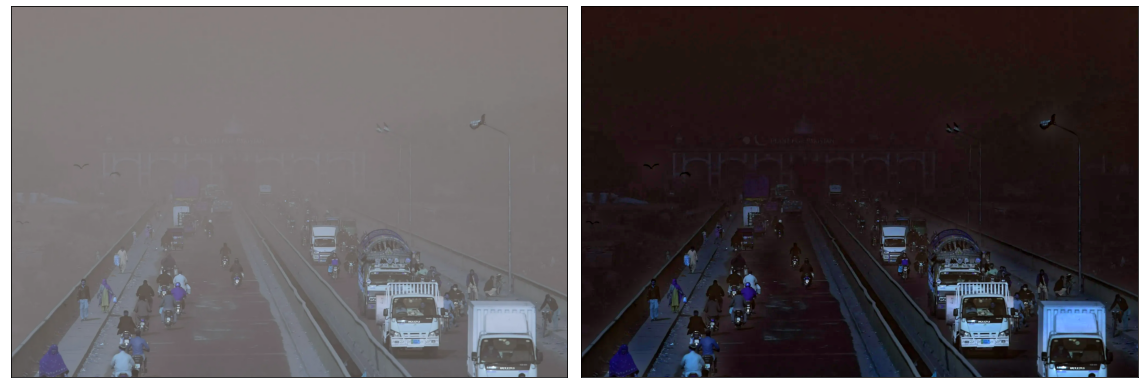

In [1]:
import cv2  
import numpy as np  
import matplotlib.pyplot as plt
   
def zmMinFilterGray(src, r=7):  
    '''''最小值滤波，r是滤波器半径'''  
    return cv2.erode(src,np.ones((2*r-1,2*r-1)))
def guidedfilter(I, p, r, eps):  
    '''''引导滤波'''  
    height, width = I.shape  
    m_I = cv2.boxFilter(I, -1, (r,r))  
    m_p = cv2.boxFilter(p, -1, (r,r))  
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))  
    cov_Ip = m_Ip-m_I*m_p  
   
    m_II = cv2.boxFilter(I*I, -1, (r,r))  
    var_I = m_II-m_I*m_I  
   
    a = cov_Ip/(var_I+eps)  
    b = m_p-a*m_I  
   
    m_a = cv2.boxFilter(a, -1, (r,r))  
    m_b = cv2.boxFilter(b, -1, (r,r))  
    return m_a*I+m_b  
   
def getV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]  
    '''''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''  
    V1 = np.min(m,2)                                         #得到暗通道图像  
    V1 = guidedfilter(V1, zmMinFilterGray(V1,7), r, eps)     #使用引导滤波优化  
    bins = 2000  
    ht = np.histogram(V1, bins)                              #计算大气光照A  
    d = np.cumsum(ht[0])/float(V1.size)  
    for lmax in range(bins-1, 0, -1):  
        if d[lmax]<=0.999:  
            break  
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()  
           
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制  
       
    return V1,A  

def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):  
    '''去雾'''
    Y = np.zeros(m.shape)  
    V1,A = getV1(m, r, eps, w, maxV1)               #得到遮罩图像和大气光照  
    for k in range(3):  
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正  
    Y =  np.clip(Y, 0, 1)  
    if bGamma:  
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作  
    return Y  
   
'''结果示例'''
img= cv2.imread('foggy.jpg')
result = deHaze(img / 255.0)
plt.figure(figsize=(16, 18))
plt.subplot(121), plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(result), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()